Importing the libraries and Loading the Data

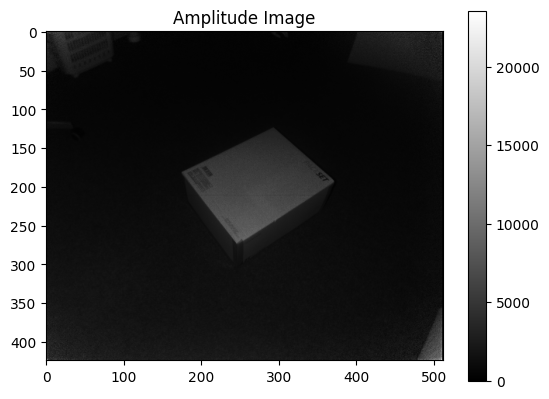

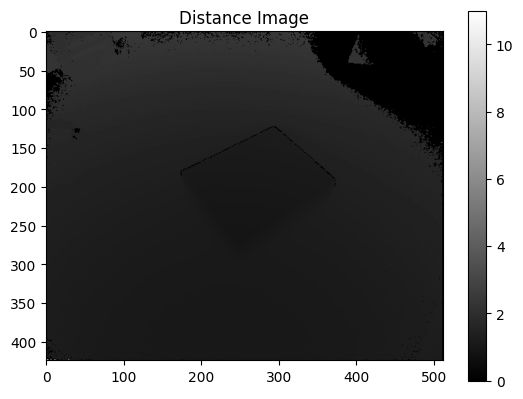

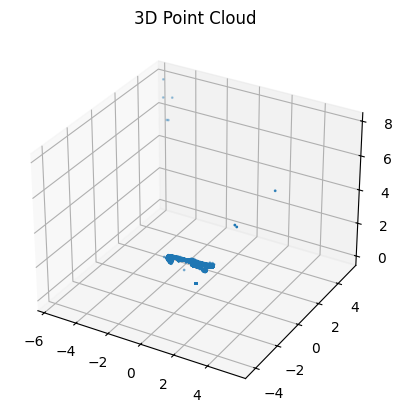

In [17]:
import scipy.io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.ndimage import binary_closing
import cv2

# Function to load data
def load_data(file_path):
    # Load .mat file
    data = scipy.io.loadmat(file_path)
    return data[list(data.keys())[3]], data[list(data.keys())[4]], data[list(data.keys())[5]]

# Visualization functions
def show_image(image, title):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.show()

def show_point_cloud(pc):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pc[:, :, 0], pc[:, :, 1], pc[:, :, 2], s=1)
    ax.set_title('3D Point Cloud')
    plt.show()

# Load your data
dataset = ['data/example1kinect.mat', 'data/example2kinect.mat', 'data/example3kinect.mat', 'data/example4kinect_corrected.mat']
amplitude_image, distance_image, point_cloud = load_data(dataset[2])

# Show images and point cloud
show_image(amplitude_image, 'Amplitude Image')
show_image(distance_image, 'Distance Image')
show_point_cloud(point_cloud)


RANSAC Function

In [18]:
def fit(samples):
    # Construct matrix A and vector b from the points
    A = samples
    b = np.ones(3)  # Since we move the plane such that d = 1
    
    try:
        # Solve the system A * n = b, where n is the normal vector [n_x, n_y, n_z]
        normal_vector = np.linalg.solve(A, b)
        d = 1  # The offset d from the origin to the plane is fixed as 1 in our formulation
        return normal_vector, d
    except np.linalg.LinAlgError:
        return None, None  # failure in calculation

def distance_to_plane(pc, normal_vector, d):
    return np.dot(pc, normal_vector) - d

def ransac_point_cloud(pc, threshold, max_iterations):
    best_plane = None
    best_inliers = []

    for _ in range(max_iterations):
        # Randomly sample 3 points to define a plane
        sample_indices = np.random.choice(pc.shape[0], 3, replace=False)
        samples = pc[sample_indices]

        if np.any(samples[:, 2] == 0):  # Skip if any z-component is zero (invalid data)
            continue

        # fit plane
        normal_vector, d = fit(samples)
        if normal_vector is None:  # Check for failure in calculation
            continue

        # Count inliers
        distances = distance_to_plane(pc, normal_vector, d)
        inliers = np.where(np.abs(distances) < threshold)[0]

        # Update best model if current one has more inliers
        if len(inliers) > len(best_inliers):
            best_plane = (normal_vector, d)
            best_inliers = inliers

    return best_plane, best_inliers

Function to find the mask image and inliers based on the calculated plane by the RANSAC function

In [19]:
def show_mask(plane, threshold, flattened_point_cloud, title):
    normal_vector, d = plane

    # Calculate the distances from points to the floor plane
    distance = distance_to_plane(flattened_point_cloud, normal_vector, d)
    mask = np.abs(distance) < threshold
    mask = mask.reshape(point_cloud.shape[:2])
    inliers = flattened_point_cloud[np.abs(distance) > threshold]

    # Visualization (assuming show_image is defined elsewhere)
    show_image(mask, title)
    return normal_vector, d, inliers, mask

RANSAC on the point cloud to find the floor plane

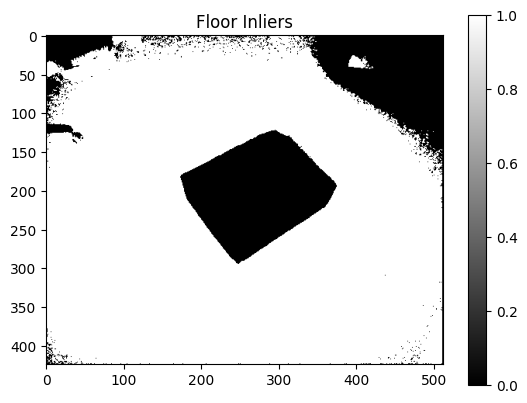

In [20]:
flattened_point_cloud = point_cloud.reshape(-1, 3)

threshold_floor = 0.05
max_iterations_floor = 100
floor_plane, floor_inliers = ransac_point_cloud(flattened_point_cloud, threshold_floor, max_iterations_floor)

floor_plane_normal, floor_plane_d, floor_inliers, _ = show_mask(floor_plane, threshold_floor, flattened_point_cloud, title='Floor Inliers')

RANSAC on the point cloud to find the box plane

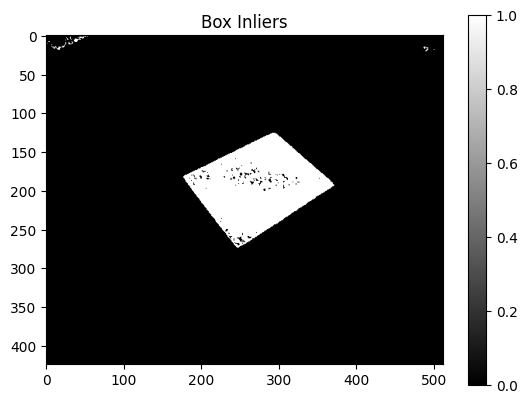

In [21]:
threshold_box = 0.006
max_iterations_box = 100

box_plane, box_inliers = ransac_point_cloud(floor_inliers, threshold_box, max_iterations_box)

box_plane_normal, box_plane_d, box_inliers, box_mask = show_mask(box_plane, threshold_box, flattened_point_cloud, title='Box Inliers')

Applying some filters on the image to find the top of the box

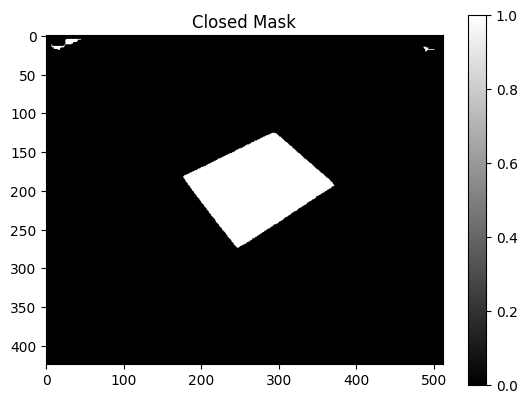

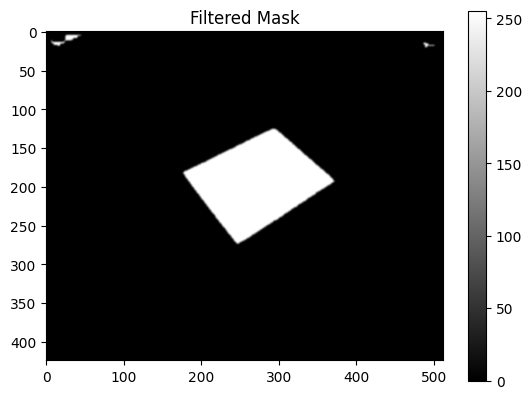

In [22]:
kernel_size = 3
iterations = 5

structure = np.ones((3, 3))

closed_mask = binary_closing(box_mask, structure, 5)
show_image(closed_mask, "Closed Mask")

def closing(mask, kernel_size):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated = cv2.dilate(mask, kernel, iterations=1)
    eroded = cv2.erode(dilated, kernel, iterations=1)
    return eroded


box_gaussian = cv2.GaussianBlur(np.uint8(closed_mask) * 255, (5, 5), 0)
filtered_mask = closing(box_gaussian, 5)

show_image(filtered_mask, "Filtered Mask")

Finding the edges and annotating the image

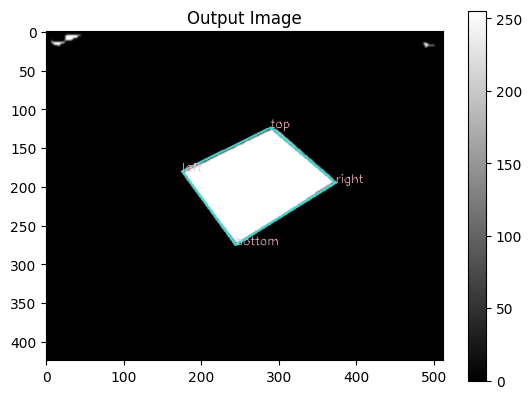

In [23]:
contours, _ = cv2.findContours(filtered_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest = max(contours, key=cv2.contourArea)

# Finding the extreme points (edges) of the box
top = tuple(largest[largest[:, :, 1].argmin()][0])
left = tuple(largest[largest[:, :, 0].argmin()][0])
bottom = tuple(largest[largest[:, :, 1].argmax()][0])
right = tuple(largest[largest[:, :, 0].argmax()][0])

# Adding annotations to the image
output_image = cv2.cvtColor(filtered_mask, cv2.COLOR_GRAY2BGR)

cv2.line(output_image, left, bottom, (72,209,204) , 2) 
cv2.line(output_image, bottom, right, (72,209,204) , 2) 
cv2.line(output_image, right, top, (72,209,204) , 2) 
cv2.line(output_image, top, left, (72,209,204) , 2) 

cv2.putText(output_image, "left", left, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,182,193),1)
cv2.putText(output_image, "right", right, cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,182,193),1)
cv2.putText(output_image, "top", top, cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,182,193),1)
cv2.putText(output_image, "bottom", bottom, cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,182,193),1)

show_image(output_image, "Output Image")

calculating the distances

In [24]:
def euclidean_distance(pt1, pt2):
    return np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)

width = euclidean_distance(left, top)
length = euclidean_distance(top, bottom)
mean_top_point = np.mean(box_inliers, axis=0)
height = abs((np.dot(floor_plane_normal, mean_top_point) + floor_plane_d) / np.linalg.norm(floor_plane_normal))
plane_distance = np.linalg.norm(floor_plane_normal- box_plane_normal)

print("Height of the box(units):", height)
print("Width:",width)
print("Length:", length)
print("Height of the box:", plane_distance)

Height of the box(units): 1.9641645558007437
Width: 127.01181047445942
Length: 157.56268593801008
Height of the box: 0.22059076115704862
